In [1]:
from torch import nn
from torch.autograd import Variable
import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn.modules.utils import _pair, _quadruple, _ntuple
from torch.nn.common_types import _size_4_t
import matplotlib.pyplot as plt
import xesmf as xe
import xarray as xr
import numpy as np

In [2]:
torch.zeros((3,3)).device

device(type='cpu')

In [3]:
_quadruple(3)

(3, 3, 3, 3)

In [4]:
class LatLonPad(nn.Module):
    __constants__ = ['padding', 'lon_dim', 'lat_mode', 'value']

    def __init__(self, padding: _size_4_t, lon_dim: int, lat_mode: str = 'constant', value: float = 0.) -> None:
        super(LatLonPad, self).__init__()
        assert lat_mode in ['constant', 'circular']
        self.padding = _quadruple(padding)
        self.lon_dim = lon_dim
        self.lat_mode = lat_mode
        self.value = value

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        is1 = self.lon_dim==2 or self.lon_dim==-2
        is2 = self.lon_dim==3 or self.lon_dim==-1
        is_circular_pad = (is1, is1, is2, is2)
        circ_padding = tuple(p if b else 0 for p, b in zip(self.padding, is_circular_pad))
        zero_padding = tuple(p if not b else 0 for p, b in zip(self.padding, is_circular_pad))
        x = F.pad(input, circ_padding, mode='circular')
        x = F.pad(x, zero_padding, self.lat_mode, self.value)
        return x

In [72]:
pad = LatLonPad(1, lon_dim=-2, value=-100)

In [74]:
pad(torch.arange(9).view(1,1,3,3))

tensor([[[[-100, -100, -100, -100, -100],
          [   2,    0,    1,    2,    0],
          [   5,    3,    4,    5,    3],
          [   8,    6,    7,    8,    6],
          [-100, -100, -100, -100, -100]]]])

In [5]:
import imp
import climatetranslation.unit.data
imp.reload(climatetranslation.unit.data)

import climatetranslation.unit.utils
imp.reload(climatetranslation.unit.utils)

<module 'climatetranslation.unit.utils' from '/home/dfulu/repos/climateTranslation/climatetranslation/unit/utils.py'>

In [6]:
from climatetranslation.unit.data import get_all_data_loaders, get_dataset, construct_regridders, reduce_height
from climatetranslation.unit.utils import get_config

In [7]:

config = get_config("/home/dfulu/repos/climateTranslation/climatetranslation/unit/configs/hadgem3_to_era5.yaml")

In [8]:
config

{'image_save_iter': 2000,
 'image_display_iter': 100,
 'display_size': 16,
 'snapshot_save_iter': 2000,
 'log_iter': 10,
 'max_iter': 1000000,
 'batch_size': 1,
 'weight_decay': 0.0001,
 'beta1': 0.5,
 'beta2': 0.999,
 'init': 'kaiming',
 'lr': 0.0001,
 'lr_policy': 'step',
 'step_size': 100000,
 'gamma': 0.5,
 'gan_w': 4,
 'recon_x_w': 10,
 'recon_h_w': 0,
 'recon_kl_w': 0.01,
 'recon_x_cyc_w': 10,
 'recon_kl_cyc_w': 0.01,
 'vgg_w': 0,
 'gen': {'dim': 64,
  'mlp_dim': 256,
  'style_dim': 8,
  'activ': 'relu',
  'n_downsample': 2,
  'n_res': 4,
  'pad_type': 'zero',
  'upsample': 'bilinear',
  'output_activ': ['relu', 'none', '-relu', 'relu', 'none']},
 'dis': {'dim': 64,
  'norm': 'none',
  'activ': 'lrelu',
  'n_layer': 4,
  'gan_type': 'lsgan',
  'num_scales': 3,
  'pad_type': 'zero'},
 'num_workers': 5,
 'data_zarr_a': '/datadrive/hadgem3/all_hist_zarr',
 'data_zarr_b': '/datadrive/era5/all_hist_zarr',
 'agg_data_a': '/datadrive/hadgem3/all_hist_era5_v1_agg.nc',
 'agg_data_b': '/da

In [9]:
conf = config

In [10]:
ds_a = get_dataset(conf['data_zarr_a'], conf['level_vars'], filter_bounds=False, split_at=conf['split_at'], bbox=conf['bbox'])
ds_b = get_dataset(conf['data_zarr_b'], conf['level_vars'], filter_bounds=False, split_at=conf['split_at'], bbox=conf['bbox'])

In [11]:
[*ds_a.keys()], [*ds_b.keys()]

(['pr', 'tas', 'tasmin', 'tasmax', 'z500'],
 ['pr', 'tas', 'tasmin', 'tasmax', 'z500'])

In [12]:
periodic = conf['bbox'] is None
rg_a, rg_b = construct_regridders(ds_a, ds_b, conf['resolution_match'], conf['scale_method'], periodic)

Create weight file: conservative_181x281_81x84.nc
Remove file conservative_181x281_81x84.nc


In [18]:
rg_a, rg_b

(None, xESMF Regridder 
 Regridding algorithm:       conservative 
 Weight filename:            conservative_181x281_81x84.nc 
 Reuse pre-computed weights? False 
 Input grid shape:           (181, 281) 
 Output grid shape:          (81, 84) 
 Output grid dimension name: ('lat', 'lon') 
 Periodic in longitude?      False)

In [19]:
rg_b(ds_b)

using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


,Array,Chunk
Bytes,835.04 MB,54.43 kB
Shape,"(1, 15341, 81, 84)","(1, 1, 81, 84)"
Count,30683 Tasks,15341 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,835.04 MB,54.43 kB
Shape,"(1, 15341, 81, 84)","(1, 1, 81, 84)"
Count,30683 Tasks,15341 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [24]:
agg_a = xr.load_dataset(conf['agg_data_a'])
agg_a

<xarray.Dataset>
Dimensions:              (aggregate_statistic: 8, lat: 81, lon: 84)
Coordinates:
  * lon                  (lon) float32 -29.583344 -28.75 ... 38.75 39.583332
  * lat                  (lat) float32 30.277782 30.833338 ... 74.16667 74.72223
  * aggregate_statistic  (aggregate_statistic) object 'mean' 'std' ... 'max_log'
Data variables:
    pr                   (aggregate_statistic, lat, lon) float32 2.124701e-05...
    tas                  (aggregate_statistic, lat, lon) float32 294.21362 .....
    tasmax               (aggregate_statistic, lat, lon) float32 294.60522 .....
    tasmin               (aggregate_statistic, lat, lon) float32 293.83734 .....
    z500                 (aggregate_statistic, lat, lon) float32 5804.561 ......
    pr_4root             (aggregate_statistic, lat, lon) float32 0.046314195 ...
Attributes:
    regrid_method:         conservative
    log_calculation_note:  Calculated from log(x-x.min()+1)

In [38]:
reduce_height(agg_a, conf['level_vars'])

<xarray.Dataset>
Dimensions:              (aggregate_statistic: 8, lat: 81, lon: 84)
Coordinates:
  * lon                  (lon) float32 -29.583344 -28.75 ... 38.75 39.583332
  * aggregate_statistic  (aggregate_statistic) object 'mean' 'std' ... 'max_log'
  * lat                  (lat) float32 30.277782 30.833338 ... 74.16667 74.72223
Data variables:
    pr                   (aggregate_statistic, lat, lon) float32 2.124701e-05...
    tas                  (aggregate_statistic, lat, lon) float32 294.21362 .....
    tasmin               (aggregate_statistic, lat, lon) float32 293.83734 .....
    tasmax               (aggregate_statistic, lat, lon) float32 294.60522 .....
    z500                 (aggregate_statistic, lat, lon) float32 5804.561 ......
Attributes:
    regrid_method:         conservative
    log_calculation_note:  Calculated from log(x-x.min()+1)

In [21]:
agg_b = xr.load_dataset(conf['agg_data_b'])
agg_b

<xarray.Dataset>
Dimensions:              (aggregate_statistic: 8, lat: 81, lon: 84)
Coordinates:
  * lon                  (lon) float32 -29.583344 -28.75 ... 38.75 39.583332
  * lat                  (lat) float32 30.277782 30.833338 ... 74.16667 74.72223
  * aggregate_statistic  (aggregate_statistic) object 'mean' 'std' ... 'max_log'
Data variables:
    pr                   (aggregate_statistic, lat, lon) float32 1.8107185e-0...
    tas                  (aggregate_statistic, lat, lon) float32 294.00287 .....
    tasmin               (aggregate_statistic, lat, lon) float32 293.4372 ......
    tasmax               (aggregate_statistic, lat, lon) float32 294.58792 .....
    z500                 (aggregate_statistic, lat, lon) float32 5817.131 ......
    pr_4root             (aggregate_statistic, lat, lon) float32 0.04952928 ....
Attributes:
    log_calculation_note:  Calculated from log(x-x.min()+1)

In [25]:
agg_a+agg_b

<xarray.Dataset>
Dimensions:              (aggregate_statistic: 8, lat: 81, lon: 84)
Coordinates:
  * lon                  (lon) float32 -29.583344 -28.75 ... 38.75 39.583332
  * lat                  (lat) float32 30.277782 30.833338 ... 74.16667 74.72223
  * aggregate_statistic  (aggregate_statistic) object 'mean' 'std' ... 'max_log'
Data variables:
    pr                   (aggregate_statistic, lat, lon) float32 3.9354192e-0...
    tas                  (aggregate_statistic, lat, lon) float32 588.2165 ......
    tasmax               (aggregate_statistic, lat, lon) float32 589.1931 ......
    tasmin               (aggregate_statistic, lat, lon) float32 587.27454 .....
    z500                 (aggregate_statistic, lat, lon) float32 11621.691 .....
    pr_4root             (aggregate_statistic, lat, lon) float32 0.09584348 ....

In [13]:
data_loaders = get_all_data_loaders(config)

start time (1979-01-01T12:00:00) and end time (2013-12-30T12:00:00)
Create weight file: conservative_181x281_81x84.nc
Remove file conservative_181x281_81x84.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


In [14]:
dl1 = data_loaders[0]

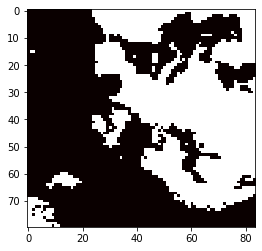

In [15]:
import matplotlib.pyplot as plt
import numpy as np

a = dl1.dataset.land_mask.numpy()[0]
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

In [16]:
[*data_loaders[0].dataset.ds.keys()]

['pr', 'tas', 'tasmin', 'tasmax', 'z500']

In [17]:
[*data_loaders[2].dataset.ds.keys()]

['pr', 'tas', 'tasmin', 'tasmax', 'z500']

In [32]:
ch = 4
n = 2000

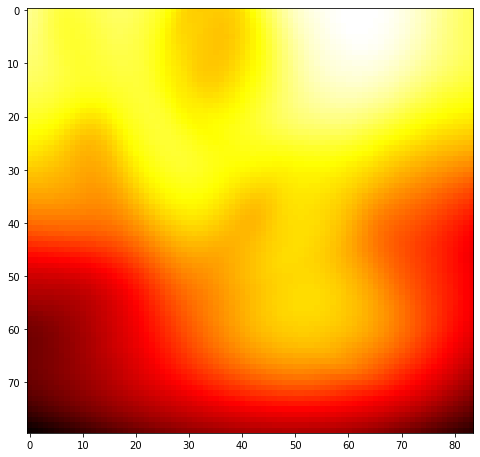

In [33]:
import matplotlib.pyplot as plt
import numpy as np

a = data_loaders[0].dataset[n].numpy()[ch]
plt.figure(figsize=(8,8))
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

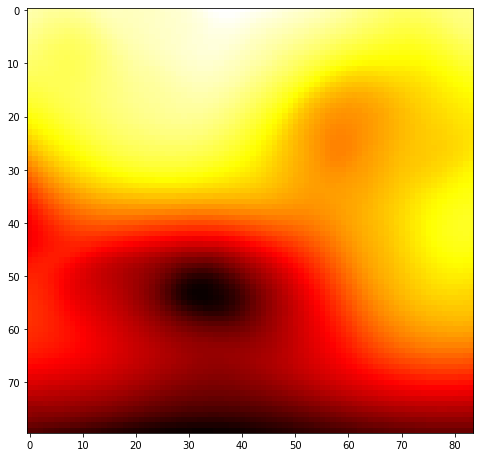

In [34]:
import matplotlib.pyplot as plt
import numpy as np

b = data_loaders[2].dataset[n].numpy()[ch]
plt.figure(figsize=(8,8))
plt.imshow(b, cmap='hot', interpolation='nearest')
plt.show()

In [24]:
a

array([[-0.02936722, -0.04253183, -0.03966262, ..., -1.0911441 ,
        -1.5139308 , -1.7389529 ],
       [-0.03434614, -0.03109718, -0.0265402 , ..., -0.7925774 ,
        -1.899924  , -1.7057881 ],
       [-0.04531666, -0.0391141 , -0.03371323, ..., -1.3097949 ,
        -1.62929   , -1.71313   ],
       ...,
       [-0.7421974 , -0.46008644, -0.39029709, ..., -0.20400935,
        -0.23810233, -0.22633012],
       [-0.63561463, -0.5608886 , -0.36329275, ..., -0.2988199 ,
        -0.3023642 , -0.29244855],
       [-0.7331678 , -0.8528308 , -0.6309311 , ..., -0.43995976,
        -0.4994115 , -0.38772324]], dtype=float32)

In [25]:
b

array([[-0.101261  , -0.06729988, -0.06573342, ..., -1.9453726 ,
        -1.8513162 , -1.7289529 ],
       [-0.09507953, -0.06471021, -0.06812266, ..., -1.8547868 ,
        -1.7818698 , -1.7739688 ],
       [-0.08127146, -0.06533257, -0.06950453, ..., -1.6717374 ,
        -1.6327921 , -1.7711365 ],
       ...,
       [-0.653869  , -0.6580409 , -0.5959784 , ..., -0.1176693 ,
        -0.09601836, -0.08849723],
       [-0.78580517, -0.869698  , -0.754439  , ..., -0.08376619,
        -0.06783786, -0.06040111],
       [-0.5860786 , -0.6118276 , -0.73291993, ..., -0.07513747,
        -0.06740537, -0.06337053]], dtype=float32)

In [1]:
#import imp
import climatetranslation.unit.data
#imp.reload(climatetranslation.unit.data)

import climatetranslation.unit.utils
#imp.reload(climatetranslation.unit.utils)

import climatetranslation.unit.trainer
#imp.reload(climatetranslation.unit.trainer)

import climatetranslation.unit.networks
#imp.reload(climatetranslation.unit.networks)

from climatetranslation.unit.trainer import UNIT_Trainer

from climatetranslation.unit.data import get_all_data_loaders, get_dataset, construct_regridders, reduce_height
from climatetranslation.unit.utils import get_config
config = get_config("/home/dfulu/repos/climateTranslation/climatetranslation/unit/configs/hadgem3_to_era5.yaml")

In [2]:
data_loaders = get_all_data_loaders(config)

start time (1979-01-01T12:00:00) and end time (2013-12-30T12:00:00)
Create weight file: conservative_181x281_81x84.nc
Remove file conservative_181x281_81x84.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


In [3]:
# Add some extra hyperpaameters with inferred info from data
hyperparams = config
hyperparams['input_dim_a'] = data_loaders[0].dataset.shape[1]
hyperparams['input_dim_b'] = data_loaders[2].dataset.shape[1]
hyperparams['land_mask_a'] = data_loaders[0].dataset.land_mask
hyperparams['land_mask_b'] = data_loaders[2].dataset.land_mask


# Setup model and data loader
trainer = UNIT_Trainer(hyperparams);
trainer.cuda();

In [22]:
trainer.gen_a.land_mask.shape

torch.Size([1, 81, 84])

In [6]:
import torch

In [20]:
ims_1 = torch.cat([data_loaders[0].dataset[i].unsqueeze(0) for i in range(2)], dim=0).cuda()
ims_2 = torch.cat([data_loaders[2].dataset[i].unsqueeze(0) for i in range(2)], dim=0).cuda()

In [21]:
trainer(ims_1, ims_2)

(tensor([[[[ 2.1804e-02,  2.4277e-01,  1.2676e-01,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  2.6996e-01,  1.3444e-01,  ...,  2.0261e-02,
             0.0000e+00,  1.5271e-02],
           [ 1.9834e-01,  3.8084e-01,  7.2267e-02,  ...,  1.5860e-01,
             6.7264e-02,  0.0000e+00],
           ...,
           [ 2.7715e-01,  4.5507e-02,  0.0000e+00,  ...,  1.8144e-01,
             0.0000e+00,  0.0000e+00],
           [ 2.4195e-01,  1.9487e-01,  0.0000e+00,  ...,  1.0362e-01,
             0.0000e+00,  0.0000e+00],
           [ 2.6003e-01,  1.3564e-01,  0.0000e+00,  ...,  3.4149e-02,
             0.0000e+00,  0.0000e+00]],
 
          [[ 1.8458e-01,  2.8741e-01,  3.3358e-01,  ..., -6.3836e-02,
             1.0024e-01,  4.8446e-02],
           [ 1.6327e-01,  2.8954e-01,  1.7106e-01,  ..., -2.6721e-01,
            -1.5497e-01, -1.4403e-01],
           [ 2.3371e-01,  2.6630e-01,  2.0730e-02,  ..., -4.5959e-01,
            -2.2687e-01, -2.2634e-01],


In [18]:
x = torch.cat([x, trainer.gen_a.land_mask.repeat(x.shape[0],1,1,1)], dim=1)

In [15]:
trainer.gen_a.cuda()

cuda-ing


In [48]:
trainer.gen_a.land_mask[:]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], device='cuda:0')

In [49]:
x = trainer.gen_a.land_mask.clone().detach().repeat(2,1,1,1)

In [50]:
x[0,:]=4000

In [52]:
x._add(x)

AttributeError: 'Tensor' object has no attribute '_add'

In [41]:
list(trainer.gen_a.parameters())[0][0]

tensor([[1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
        [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
        [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
        ...,
        [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
        [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
        [1000., 1000., 1000.,  ..., 1000., 1000., 1000.]], device='cuda:0')

In [197]:
dz500 = xr.open_dataset("/datadrive/era5/era5_z500_daily_eu.nc")

In [209]:
level_vars = {k:v for k,v in config['level_vars'].items() if k!=0}
ds_a[[vi for _, v in level_vars.items() for vi in v]]

,Array,Chunk
Bytes,41.05 GB,221.18 kB
Shape,"(9, 20621, 192, 288)","(1, 1, 192, 288)"
Count,556768 Tasks,185589 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,41.05 GB,221.18 kB
Shape,"(9, 20621, 192, 288)","(1, 1, 192, 288)"
Count,556768 Tasks,185589 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [202]:
dz500.isel(lev=0).drop('lev')

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 281, time: 15341)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T11:30:00 ... 2020-12-31T11:30:00
  * lon      (lon) float64 -30.0 -29.75 -29.5 -29.25 ... 39.25 39.5 39.75 40.0
  * lat      (lat) float64 75.0 74.75 74.5 74.25 74.0 ... 30.75 30.5 30.25 30.0
Data variables:
    z500     (time, lat, lon) float32 ...
Attributes:
    CDI:                        Climate Data Interface version 1.9.8 (https:/...
    institution:                European Centre for Medium-Range Weather Fore...
    Conventions:                CF-1.4
    title:                      "ERA5 reanalysis, https://www.ecmwf.int/en/fo...
    CDO:                        Climate Data Operators version 1.9.8 (https:/...
    history:                    Thu Jan  7 18:40:56 2021: ncatted -a title,gl...
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...
    geospatial_lat_min:         29.875
    geospatial_lat_max:         75.125
    geospatial_lat_units:       degrees_north
    geospatial_lon_min:         -30.125
    geospatial_lon_max:         40.125
    geospatial_lon_units:       degrees_east
    geospatial_lat_resolution:  0.25
    geospatial_lon_resolution:  0.25
    time_coverage_start:        1979-01-01
    time_coverage_end:          2020-12-31
    climexp_url:                https://climexp.knmi.nl/select.cgi?era5_z500_...

In [194]:
dz500.std(dim=('time'))

<xarray.DataArray 'z500' (lev: 1, lat: 181, lon: 281)>
array([[[1768.9816 , 1767.7906 , 1766.6038 , ..., 1937.691  ,
         1938.5582 , 1939.421  ],
        [1769.4932 , 1768.2998 , 1767.109  , ..., 1938.4839 ,
         1939.358  , 1940.2236 ],
        [1770.0114 , 1768.6964 , 1767.3866 , ..., 1939.323  ,
         1940.2145 , 1941.0988 ],
        ...,
        [ 767.86646,  768.6989 ,  769.5787 , ...,  941.987  ,
          940.6556 ,  939.9848 ],
        [ 758.5077 ,  759.4168 ,  760.36615, ...,  928.5372 ,
          927.5268 ,  926.7136 ],
        [ 749.283  ,  750.272  ,  751.28284, ...,  914.76447,
          913.7403 ,  912.8158 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -30.0 -29.75 -29.5 -29.25 ... 39.25 39.5 39.75 40.0
  * lat      (lat) float64 75.0 74.75 74.5 74.25 74.0 ... 30.75 30.5 30.25 30.0
  * lev      (lev) float64 5e+04

In [212]:
import mpl_toolkits.basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [4]:
ls /datadrive/hadgem3/allhistzg

dl.log  dl.py  dlzg.sh  zg_Aday_HadGEM3-A-N216_All-Hist_est1_v1-0_r1i1p1.tar


In [9]:
dzg = xr.load_dataset("/datadrive/hadgem3/allhistzg/zg_Aday_HadGEM3-A-N216_All-Hist_est1_v1-0_r1i1p1_20100101-20131230.nc")
dzg

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 325, lon: 432, plev: 5, time: 1440)
Coordinates:
  * lat        (lat) float32 -90.0 -89.44444 -88.88889 ... 89.44445 90.0
  * lon        (lon) float32 0.0 0.8333333 1.6666666 ... 358.3333 359.16666
  * plev       (plev) float32 100000.0 85000.0 70000.0 50000.0 25000.0
  * time       (time) object 2010-01-01 12:00:00 ... 2013-12-30 12:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float32 -90.0 -89.72222 -89.72222 ... 89.72223 90.0
    lon_bnds   (lon, bnds) float32 -0.41666666 0.41666666 ... 358.75 359.5833
    time_bnds  (time, bnds) object 2010-01-01 00:00:00 ... 2014-01-01 00:00:00
    zg         (time, plev, lat, lon) float32 nan nan nan ... 9908.445 9908.441
Attributes:
    institution:               Met Office Hadley Centre, Fitzroy Road, Exeter...
    institute_id:              MOHC
    source:                    MOHC Unified Model [N216L85]
    model_id:                  HadGEM3-A-N216
    forcing:                   GHG, Oz, LU, Sl, Vl, AA, (GHG = CO2, N2O, CH4,...
    parent_experiment_id:      N/A
    parent_experiment_rip:     N/A
    branch_time:               0.0
    contact:                   peter.stott@metoffice.gov.uk, andrew.ciavarell...
    history:                   2016-04-01T23:34:51Z: Naming and attribute con...
    initialization_method:     1
    physics_version:           1
    tracking_id:               5f2e030d-e9dd-4b2c-a51a-8155573f6f55
    mo_runid:                  aojaa
    product:                   output
    experiment:                est1
    frequency:                 day
    creation_date:             2016-04-01T23:34:51Z
    project_id:                EUCLEIA, and C20C+ Detection and Attribution P...
    table_id:                  Table day (13 January 2015) 159846346d11cd9e5d...
    title:                     HadGEM3-A-N216 model output prepared for EUCLE...
    parent_experiment:         N/A
    modeling_realm:            atmos
    realization:               1
    cmor_version:              2.9.1
    experiment_family:         All-Hist
    parent_experiment_family:  N/A
    orig_experiment_id:        historical
    subexperiment:             v1-0
    parent_subexperiment:      N/A
    orig_project_id:           EUCLEIA
    run_id:                    r1i1p1
    acknowledgement:           This simulation was performed under funding fr...
    parent_run_id:             N/A
    license:                   I agree to restrict my use of EUCLEIA model ou...

In [25]:
dzg.time[dzg.sel(plev=50000)[['zg']].isnull().any(dim=('lat', 'lon')).zg]

<xarray.DataArray 'time' (time: 2)>
array([cftime.Datetime360Day(2012, 2, 27, 12, 0, 0, 0),
       cftime.Datetime360Day(2012, 2, 28, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 2012-02-27 12:00:00 2012-02-28 12:00:00
    plev     float32 50000.0
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

In [26]:
dzg.time.max()

<xarray.DataArray 'time' ()>
array(cftime.Datetime360Day(2013, 12, 30, 12, 0, 0, 0), dtype=object)

In [12]:
ds = xr.open_zarr("/datadrive/hadgem3/all_hist_zarr")

In [18]:
import xarray as xr
import xesmf as xe
from climatetranslation.unit.data import _quick_add_bounds, _quick_remove_bounds


chunk_dict = {'time': 1, 'run':1, 'height':1}

ds = xr.open_mfdataset("/datadrive/hadgem3/allhistzg/zg_*.nc")
ds= ds.sel(plev=50000)[['zg']] \
    .drop('plev') \
    .expand_dims({'run':[1]}) \
    .expand_dims({'height':[5500.]}) \
    .rename({'zg':'z500'}) \
    .transpose('run', 'time', 'height', 'lat', 'lon')
    

# regrid the data
ds_main = xr.open_zarr("/datadrive/hadgem3/all_hist_zarr").sel(run=[1,])
ds_out = ds_main[['lat', 'lon']]
_quick_add_bounds(ds_out)
_quick_add_bounds(ds)
regridder = xe.Regridder(ds, ds_out, 'conservative', periodic=True)
regridder.clean_weight_file()
ds = regridder(ds)
_quick_remove_bounds(ds)

ds = ds_main.merge(ds).chunk(chunk_dict)

Create weight file: conservative_325x432_324x432.nc
Remove file conservative_325x432_324x432.nc
using dimensions ('lat', 'lon') from data variable z500 as the horizontal dimensions for this dataset.


In [20]:
list(ds.keys())

['pr', 'tas', 'tasmax', 'tasmin', 'z500']

In [8]:
xr.open_mfdataset("/datadrive/hadgem3/allhistzg/zg_*.nc")

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 325, lon: 432, plev: 5, time: 19440)
Coordinates:
  * plev       (plev) float32 100000.0 85000.0 70000.0 50000.0 25000.0
  * lat        (lat) float32 -90.0 -89.44444 -88.88889 ... 89.44445 90.0
  * lon        (lon) float32 0.0 0.8333333 1.6666666 ... 358.3333 359.16666
  * time       (time) object 1960-01-01 12:00:00 ... 2013-12-30 12:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (time, lat, bnds) float32 dask.array<chunksize=(3600, 325, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float32 dask.array<chunksize=(3600, 432, 2), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(3600, 2), meta=np.ndarray>
    zg         (time, plev, lat, lon) float32 dask.array<chunksize=(3600, 5, 325, 432), meta=np.ndarray>
Attributes:
    institution:               Met Office Hadley Centre, Fitzroy Road, Exeter...
    institute_id:              MOHC
    source:                    MOHC Unified Model [N216L85]
    model_id:                  HadGEM3-A-N216
    forcing:                   GHG, Oz, LU, Sl, Vl, AA, (GHG = CO2, N2O, CH4,...
    parent_experiment_id:      N/A
    parent_experiment_rip:     N/A
    branch_time:               0.0
    contact:                   peter.stott@metoffice.gov.uk, andrew.ciavarell...
    history:                   2016-04-01T23:11:38Z: Naming and attribute con...
    initialization_method:     1
    physics_version:           1
    tracking_id:               b16b6bb2-42e1-4e2f-bfbb-d11ef706e2ab
    mo_runid:                  aojaa
    product:                   output
    experiment:                est1
    frequency:                 day
    creation_date:             2016-04-01T23:11:38Z
    project_id:                EUCLEIA, and C20C+ Detection and Attribution P...
    table_id:                  Table day (13 January 2015) 159846346d11cd9e5d...
    title:                     HadGEM3-A-N216 model output prepared for EUCLE...
    parent_experiment:         N/A
    modeling_realm:            atmos
    realization:               1
    cmor_version:              2.9.1
    experiment_family:         All-Hist
    parent_experiment_family:  N/A
    orig_experiment_id:        historical
    subexperiment:             v1-0
    parent_subexperiment:      N/A
    orig_project_id:           EUCLEIA
    run_id:                    r1i1p1
    acknowledgement:           This simulation was performed under funding fr...
    parent_run_id:             N/A
    license:                   I agree to restrict my use of EUCLEIA model ou...

In [14]:
ds

,Array,Chunk
Bytes,152.37 GB,1.12 MB
Shape,"(7, 19440, 2, 324, 432)","(1, 1, 2, 324, 432)"
Count,136081 Tasks,136080 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,152.37 GB,1.12 MB
Shape,"(7, 19440, 2, 324, 432)","(1, 1, 2, 324, 432)"
Count,136081 Tasks,136080 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [25]:
dse = xr.open_zarr("/datadrive/era5/all_hist_zarr")

In [6]:
dse

,Array,Chunk
Bytes,3.12 GB,203.44 kB
Shape,"(1, 15341, 181, 281)","(1, 1, 181, 281)"
Count,15342 Tasks,15341 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.12 GB,203.44 kB
Shape,"(1, 15341, 181, 281)","(1, 1, 181, 281)"
Count,15342 Tasks,15341 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [29]:
dsh = xr.open_zarr('/datadrive/hadgem3/all_hist_zarr')
dsh

,Array,Chunk
Bytes,32.65 GB,559.87 kB
Shape,"(1, 19440, 3, 324, 432)","(1, 1, 1, 324, 432)"
Count,58321 Tasks,58320 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,32.65 GB,559.87 kB
Shape,"(1, 19440, 3, 324, 432)","(1, 1, 1, 324, 432)"
Count,58321 Tasks,58320 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [30]:
dse.time

<xarray.DataArray 'time' (time: 15341)>
array(['1979-01-01T12:00:00.000000000', '1979-01-02T12:00:00.000000000',
       '1979-01-03T12:00:00.000000000', ..., '2020-12-29T12:00:00.000000000',
       '2020-12-30T12:00:00.000000000', '2020-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T12:00:00 ... 2020-12-31T12:00:00

In [31]:
dsh.time

<xarray.DataArray 'time' (time: 19440)>
array([cftime.Datetime360Day(1960, 1, 1, 12, 0, 0, 0),
       cftime.Datetime360Day(1960, 1, 2, 12, 0, 0, 0),
       cftime.Datetime360Day(1960, 1, 3, 12, 0, 0, 0), ...,
       cftime.Datetime360Day(2013, 12, 28, 12, 0, 0, 0),
       cftime.Datetime360Day(2013, 12, 29, 12, 0, 0, 0),
       cftime.Datetime360Day(2013, 12, 30, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1960-01-01 12:00:00 ... 2013-12-30 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

In [38]:
isinstance(dsh.time.values.min(), np.datetime64)

False

In [144]:
import cftime
import datetime
    
def any_calendar_to_string(dt):
    if isinstance(dt, np.datetime64):
        return str(dt).split('.')[0]
    elif isinstance(dt, datetime.datetime):
        return dt.strftime("%Y-%m-%dT%H:%M:%S")
    elif isinstance(dt, cftime.datetime):
        return dt.strftime().replace(' ', 'T')


def any_calendar_to_datetime(dt):
    if isinstance(dt, datetime.datetime):
        return dt
    elif isinstance(dt, np.datetime64):
        return datetime.datetime.strptime(
        str(dt).split('.')[0], 
        "%Y-%m-%dT%H:%M:%S"
        )
    elif isinstance(dt, cftime.datetime):
        return datetime.datetime.strptime(
            dt.strftime(),
            "%Y-%m-%d %H:%M:%S"
        )


def datemin_to_string(dts):
    dts = [any_calendar_to_datetime(dt) for dt in dts]
    return any_calendar_to_string(min(dts))


def datemax_to_string(dts):
    dts = [any_calendar_to_datetime(dt) for dt in dts]
    return any_calendar_to_string(max(dts))


def dataset_time_overlap(datasets_list):
    start_time = datemax_to_string([ds.time.values.min() for ds in datasets_list])
    end_time = datemin_to_string([ds.time.values.max() for ds in datasets_list])
    if (
        datetime.datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%S") >=
        datetime.datetime.strptime(end_time, "%Y-%m-%dT%H:%M:%S")
    ):
        raise ValueError("start time ({}) and end time ({}) leave no overlap".format(start_time, end_time))
    print("start time ({}) and end time ({})".format(start_time, end_time))
    return [ds.sel(time=slice(start_time, end_time)) for ds in datasets_list]

In [145]:
dataset_time_overlap([dse, dsh])

start time (1979-01-01T12:00:00) and end time (2013-12-30T12:00:00)


[<xarray.Dataset>
 Dimensions:  (lat: 181, lon: 281, run: 1, time: 12783)
 Coordinates:
   * lat      (lat) float64 30.0 30.25 30.5 30.75 31.0 ... 74.25 74.5 74.75 75.0
   * lon      (lon) float64 -30.0 -29.75 -29.5 -29.25 ... 39.25 39.5 39.75 40.0
   * run      (run) int64 1
   * time     (time) datetime64[ns] 1979-01-01T12:00:00 ... 2013-12-30T12:00:00
 Data variables:
     pr       (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 181, 281), meta=np.ndarray>
     tas      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 181, 281), meta=np.ndarray>
     tasmax   (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 181, 281), meta=np.ndarray>
     tasmin   (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 181, 281), meta=np.ndarray>
     z500     (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 181, 281), meta=np.ndarray>
 Attributes:
     CDI:                        Climate Data Interface version 1.9.8 (https:/...
     CDO:                      

In [143]:
dse.time.sel(time=slice("1979-01-01T12:00", "1998-01-01"))

<xarray.DataArray 'time' (time: 6941)>
array(['1979-01-01T12:00:00.000000000', '1979-01-02T12:00:00.000000000',
       '1979-01-03T12:00:00.000000000', ..., '1997-12-30T12:00:00.000000000',
       '1997-12-31T12:00:00.000000000', '1998-01-01T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T12:00:00 ... 1998-01-01T12:00:00

In [98]:
datetime.datetime.(t.strftime())

TypeError: an integer is required (got type str)

In [97]:
t1= np.datetime64(t.strftime())
t1

numpy.datetime64('1960-01-01T12:00:00')

In [88]:
[
    any_calendar_to_string(dse.time.values.min()),
    any_calendar_to_string(dsh.time.values.min()),
    any_calendar_to_string(datetime.datetime.utcnow())
    
]

['1979-01-01 12:00:00', '1960-01-01 12:00:00', '2021-01-21 14:24:50']

In [81]:
datetime.datetime.strptime(str(t).split('.')[0], "%Y-%m-%dT%H:%M:%S")

datetime.datetime(1979, 1, 1, 12, 0)

In [74]:
t, t.strftime()

AttributeError: 'numpy.datetime64' object has no attribute 'strftime'

In [72]:
import datetime
isinstance(datetime.datetime.utcnow(), datetime.datetime)
dt = datetime.datetime.utcnow()
dt.strftime("%Y-%m-%d %H:%M:%S")
#dt.strptime()

'2021-01-21 14:17:19'

In [54]:
dsh.sel(time=slice("1972", "1976"))

,Array,Chunk
Bytes,3.02 GB,559.87 kB
Shape,"(1, 1800, 3, 324, 432)","(1, 1, 1, 324, 432)"
Count,63721 Tasks,5400 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.02 GB,559.87 kB
Shape,"(1, 1800, 3, 324, 432)","(1, 1, 1, 324, 432)"
Count,63721 Tasks,5400 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [148]:
dse.lat

<xarray.DataArray 'lat' (lat: 181)>
array([30.  , 30.25, 30.5 , 30.75, 31.  , 31.25, 31.5 , 31.75, 32.  , 32.25,
       32.5 , 32.75, 33.  , 33.25, 33.5 , 33.75, 34.  , 34.25, 34.5 , 34.75,
       35.  , 35.25, 35.5 , 35.75, 36.  , 36.25, 36.5 , 36.75, 37.  , 37.25,
       37.5 , 37.75, 38.  , 38.25, 38.5 , 38.75, 39.  , 39.25, 39.5 , 39.75,
       40.  , 40.25, 40.5 , 40.75, 41.  , 41.25, 41.5 , 41.75, 42.  , 42.25,
       42.5 , 42.75, 43.  , 43.25, 43.5 , 43.75, 44.  , 44.25, 44.5 , 44.75,
       45.  , 45.25, 45.5 , 45.75, 46.  , 46.25, 46.5 , 46.75, 47.  , 47.25,
       47.5 , 47.75, 48.  , 48.25, 48.5 , 48.75, 49.  , 49.25, 49.5 , 49.75,
       50.  , 50.25, 50.5 , 50.75, 51.  , 51.25, 51.5 , 51.75, 52.  , 52.25,
       52.5 , 52.75, 53.  , 53.25, 53.5 , 53.75, 54.  , 54.25, 54.5 , 54.75,
       55.  , 55.25, 55.5 , 55.75, 56.  , 56.25, 56.5 , 56.75, 57.  , 57.25,
       57.5 , 57.75, 58.  , 58.25, 58.5 , 58.75, 59.  , 59.25, 59.5 , 59.75,
       60.  , 60.25, 60.5 , 60.75, 61.  , 61.25, 61.5 , 61.75, 62.  , 62.25,
       62.5 , 62.75, 63.  , 63.25, 63.5 , 63.75, 64.  , 64.25, 64.5 , 64.75,
       65.  , 65.25, 65.5 , 65.75, 66.  , 66.25, 66.5 , 66.75, 67.  , 67.25,
       67.5 , 67.75, 68.  , 68.25, 68.5 , 68.75, 69.  , 69.25, 69.5 , 69.75,
       70.  , 70.25, 70.5 , 70.75, 71.  , 71.25, 71.5 , 71.75, 72.  , 72.25,
       72.5 , 72.75, 73.  , 73.25, 73.5 , 73.75, 74.  , 74.25, 74.5 , 74.75,
       75.  ])
Coordinates:
  * lat      (lat) float64 30.0 30.25 30.5 30.75 31.0 ... 74.25 74.5 74.75 75.0
Attributes:
    axis:           Y
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

In [149]:
dse

,Array,Chunk
Bytes,3.12 GB,203.44 kB
Shape,"(1, 15341, 181, 281)","(1, 1, 181, 281)"
Count,15342 Tasks,15341 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.12 GB,203.44 kB
Shape,"(1, 15341, 181, 281)","(1, 1, 181, 281)"
Count,15342 Tasks,15341 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [153]:
np.diff(dsh.lat.values).mean() *np.diff(dsh.lon.values).mean()

0.46296296

In [154]:
np.diff(dse.lat.values).mean()* np.diff(dse.lon.values).mean()

0.0625

In [155]:
0.46296296/ 0.0625

7.40740736

In [17]:
ds.lon.values

array([  0.41666666,   1.25      ,   2.0833333 ,   2.9166665 ,
         3.75      ,   4.583333  ,   5.4166665 ,   6.25      ,
         7.083333  ,   7.9166665 ,   8.75      ,   9.583333  ,
        10.416666  ,  11.25      ,  12.083333  ,  12.916666  ,
        13.75      ,  14.583333  ,  15.416666  ,  16.25      ,
        17.083332  ,  17.916666  ,  18.75      ,  19.583332  ,
        20.416666  ,  21.25      ,  22.083332  ,  22.916666  ,
        23.75      ,  24.583332  ,  25.416666  ,  26.25      ,
        27.083332  ,  27.916666  ,  28.75      ,  29.583332  ,
        30.416666  ,  31.25      ,  32.083332  ,  32.916664  ,
        33.75      ,  34.583332  ,  35.416664  ,  36.25      ,
        37.083332  ,  37.916664  ,  38.75      ,  39.583332  ,
        40.416664  ,  41.25      ,  42.083332  ,  42.916664  ,
        43.75      ,  44.583332  ,  45.416664  ,  46.25      ,
        47.083332  ,  47.916664  ,  48.75      ,  49.583332  ,
        50.416664  ,  51.25      ,  52.083332  ,  52.91

In [25]:
from global_land_mask import globe
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


# Lat/lon points to get
lat = ds.lat.values
lon = ds.lon.values
lon[lon>180] = lon[lon>180]-360
lon[lon<=-180] = lon[lon<=-180]+360

# Make a grid
lon_grid, lat_grid = np.meshgrid(lon,lat)

# Get whether the points are on land.
z = globe.is_land(lat_grid, lon_grid).astype(float)

ds['land'] = xr.DataArray(z)


In [22]:
ds

,Array,Chunk
Bytes,32.65 GB,559.87 kB
Shape,"(1, 19440, 3, 324, 432)","(1, 1, 1, 324, 432)"
Count,58321 Tasks,58320 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,32.65 GB,559.87 kB
Shape,"(1, 19440, 3, 324, 432)","(1, 1, 1, 324, 432)"
Count,58321 Tasks,58320 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [21]:
ds['land'] = xr.DataArray(z, coords=(ds.lat, ds.lon))

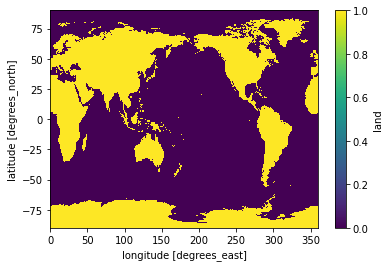

In [23]:
ds.land.plot()

In [26]:
torch.expand

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
torch.from_numpy(torch.expand)

AttributeError: module 'torch' has no attribute 'expand'

In [36]:
torch.from_numpy(globe.is_land(lat_grid, lon_grid).astype(np.float32)).repeat(3,1,1,1).shape

torch.Size([3, 1, 324, 432])

In [30]:
torch.expand

AttributeError: module 'torch' has no attribute 'expand'

In [114]:
dsaggh = xr.load_dataset("/datadrive/hadgem3/all_hist_era5_v1_agg.nc")

In [115]:
dsagge = xr.load_dataset("/datadrive/era5/all_hist_hadgem3_v1_agg.nc")

In [116]:
dsaggh

<xarray.Dataset>
Dimensions:              (aggregate_statistic: 8, lat: 81, lon: 84)
Coordinates:
  * lon                  (lon) float32 -29.583344 -28.75 ... 38.75 39.583332
  * lat                  (lat) float32 30.277782 30.833338 ... 74.16667 74.72223
  * aggregate_statistic  (aggregate_statistic) object 'mean' 'std' ... 'max_log'
Data variables:
    pr                   (aggregate_statistic, lat, lon) float32 2.124701e-05...
    tas                  (aggregate_statistic, lat, lon) float32 294.21362 .....
    tasmax               (aggregate_statistic, lat, lon) float32 294.60522 .....
    tasmin               (aggregate_statistic, lat, lon) float32 293.83734 .....
    z500                 (aggregate_statistic, lat, lon) float32 5804.561 ......
    pr_4root             (aggregate_statistic, lat, lon) float32 0.046314195 ...
Attributes:
    regrid_method:         conservative
    log_calculation_note:  Calculated from log(x-x.min()+1)

In [117]:
dsagge

<xarray.Dataset>
Dimensions:              (aggregate_statistic: 8, lat: 81, lon: 84)
Coordinates:
  * lon                  (lon) float32 -29.583344 -28.75 ... 38.75 39.583332
  * lat                  (lat) float32 30.277782 30.833338 ... 74.16667 74.72223
  * aggregate_statistic  (aggregate_statistic) object 'mean' 'std' ... 'max_log'
Data variables:
    pr                   (aggregate_statistic, lat, lon) float32 1.8107185e-0...
    tas                  (aggregate_statistic, lat, lon) float32 294.00287 .....
    tasmin               (aggregate_statistic, lat, lon) float32 293.4372 ......
    tasmax               (aggregate_statistic, lat, lon) float32 294.58792 .....
    z500                 (aggregate_statistic, lat, lon) float32 5817.131 ......
    pr_4root             (aggregate_statistic, lat, lon) float32 0.04952928 ....
Attributes:
    log_calculation_note:  Calculated from log(x-x.min()+1)

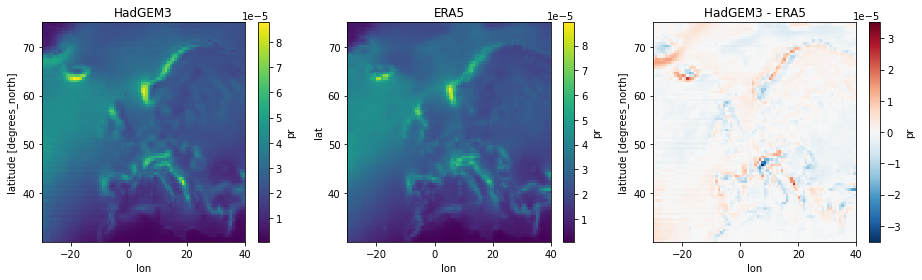

In [118]:
def plot(variable, stat):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13, 4))
    dsaggh[variable].sel(aggregate_statistic=stat).plot(ax=ax1)
    dsagge[variable].sel(aggregate_statistic=stat).plot(ax=ax2)
    (
        dsaggh[variable].sel(aggregate_statistic=stat)
        - dsagge[variable].sel(aggregate_statistic=stat) 
    ).plot(ax=ax3)
    ax1.set_title('HadGEM3')
    ax2.set_title('ERA5')
    ax3.set_title('HadGEM3 - ERA5')
    plt.tight_layout()
    plt.show()
    
plot('pr', 'mean')

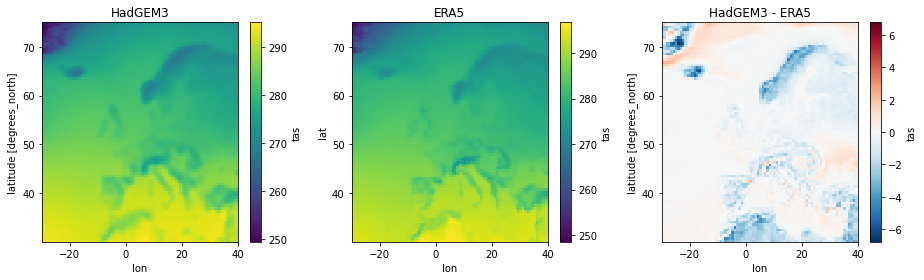

In [119]:
plot('tas', 'mean')

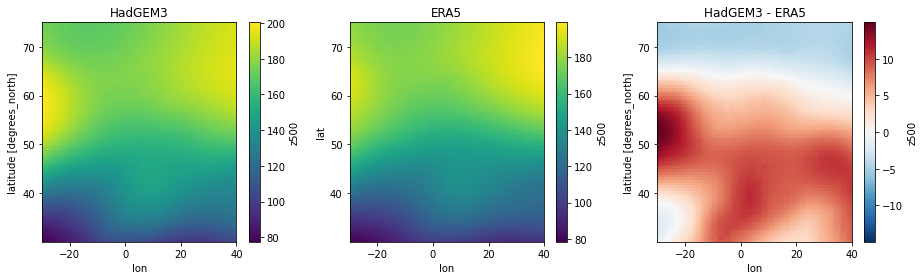

In [123]:
plot('z500', 'std')

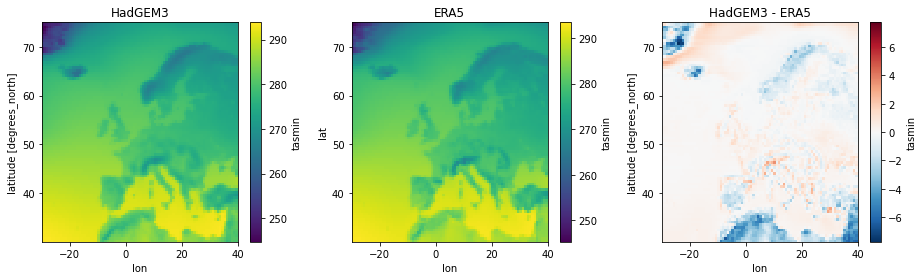

In [121]:
plot('tasmin', 'mean')

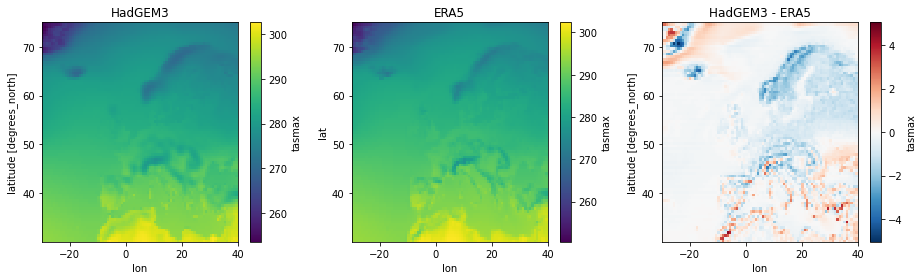

In [105]:
plot('tasmax', 'mean')

In [99]:
from climatetranslation.get_data.netcdfs_to_zarr import save_to_zarr


In [101]:
save_to_zarr(dse, "/datadrive/era5/all_hist_zarr2")

    save_to_zarr()
        chunking
        saving


In [107]:
dse = xr.open_zarr("/datadrive/era5/all_hist_zarr")

In [113]:
n = np.isnan(dse).sum(dim=('lat', 'lon', 'run')).compute()

In [125]:
n.sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    pr       int64 0
    tas      int64 0
    tasmax   int64 0
    tasmin   int64 0
    z500     int64 0

In [103]:
dse.z500.isel(time=0, run=0).load()

<xarray.DataArray 'z500' (lat: 181, lon: 281)>
array([[5822.364 , 5824.744 , 5827.139 , ..., 5721.201 , 5721.1587,
        5720.8613],
       [5819.3267, 5821.7676, 5824.1978, ..., 5719.279 , 5719.0566,
        5718.742 ],
       [5816.2407, 5818.717 , 5821.1357, ..., 5717.195 , 5716.9194,
        5716.6113],
       ...,
       [5174.5654, 5174.22  , 5173.8164, ..., 4832.3823, 4828.743 ,
        4825.1406],
       [5175.991 , 5175.6436, 5175.257 , ..., 4826.5947, 4823.0947,
        4819.623 ],
       [5177.17  , 5176.848 , 5176.505 , ..., 4821.0317, 4817.66  ,
        4814.3335]], dtype=float32)
Coordinates:
  * lat      (lat) float64 30.0 30.25 30.5 30.75 31.0 ... 74.25 74.5 74.75 75.0
  * lon      (lon) float64 -30.0 -29.75 -29.5 -29.25 ... 39.25 39.5 39.75 40.0
    run      int64 1
    time     datetime64[ns] 1979-01-01T12:00:00

In [66]:
dsh = xr.open_zarr('/datadrive/hadgem3/all_hist_zarr')

In [67]:
dsh.z500.isel(time=0, run=0).sel(height=5500).load()

<xarray.DataArray 'z500' (lat: 324, lon: 432)>
array([[5073.1123, 5073.1924, 5073.274 , ..., 5072.8765, 5072.9536,
        5072.9697],
       [5068.8174, 5068.982 , 5069.1475, ..., 5068.335 , 5068.493 ,
        5068.5913],
       [5064.229 , 5064.492 , 5064.756 , ..., 5063.453 , 5063.71  ,
        5063.906 ],
       ...,
       [5207.448 , 5207.772 , 5208.093 , ..., 5206.472 , 5206.799 ,
        5207.0605],
       [5206.181 , 5206.3584, 5206.534 , ..., 5205.6445, 5205.824 ,
        5205.939 ],
       [5204.9155, 5204.9927, 5205.07  , ..., 5204.678 , 5204.7583,
        5204.773 ]], dtype=float32)
Coordinates:
    height   float32 5500.0
  * lat      (lat) float32 -89.72222 -89.166664 -88.611115 ... 89.16667 89.72223
  * lon      (lon) float32 0.41666666 1.25 2.0833333 ... 358.75 359.5833
    run      int64 1
    time     object 1960-01-01 12:00:00

In [79]:
import os

In [80]:
os.makedirs("/datadrive/tmp")

In [81]:
os.system("wget -P /datadrive/tmp/ https://climexp.knmi.nl/ERA5/era5_z500_daily_eu.nc")

0

In [84]:
z500e = xr.open_dataset("/datadrive/tmp/era5_z500_daily_eu.nc")
z500e.z500

<xarray.DataArray 'z500' (time: 15341, lev: 1, lat: 181, lon: 281)>
[780258601 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T11:30:00 ... 2020-12-31T11:30:00
  * lon      (lon) float64 -30.0 -29.75 -29.5 -29.25 ... 39.25 39.5 39.75 40.0
  * lat      (lat) float64 75.0 74.75 74.5 74.25 74.0 ... 30.75 30.5 30.25 30.0
  * lev      (lev) float64 5e+04
Attributes:
    standard_name:  geopotential_height
    long_name:      Geopotential Height
    units:          m2 s-2
    code:           129
    table:          128
    institution:    ECMWF

In [85]:
!wget -O /datadrive/tmp/zg_Aday_HadGEM3-A-N216_All-Hist_est1_v1-0_r1i1p1.tar "http://portal.nersc.gov/cascade/data/rtrack.php?source=NERSCHPSS&filename=C20C/MOHC/HadGEM3-A-N216/All-Hist/est1/v1-0/day/atmos/zg/r1i1p1/zg_Aday_HadGEM3-A-N216_All-Hist_est1_v1-0_r1i1p1.tar"

0

In [88]:
!tar -xvf /datadrive/tmp/zg_Aday_HadGEM3-A-N216_All-Hist_est1_v1-0_r1i1p1.tar -C /datadrive/tmp/

In [8]:
ls /datadrive/tmp/

detar.log
dl.log
era5_z500_daily_eu.nc
tmp/
zg_Aday_HadGEM3-A-N216_All-Hist_est1_v1-0_r1i1p1.tar
zg_Aday_HadGEM3-A-N216_All-Hist_est1_v1-0_r1i1p1_19600101-19691230.nc
zg_Aday_HadGEM3-A-N216_All-Hist_est1_v1-0_r1i1p1_19700101-19791230.nc
zg_Aday_HadGEM3-A-N216_All-Hist_est1_v1-0_r1i1p1_19800101-19891230.nc
zg_Aday_HadGEM3-A-N216_All-Hist_est1_v1-0_r1i1p1_19900101-19991230.nc
zg_Aday_HadGEM3-A-N216_All-Hist_est1_v1-0_r1i1p1_20000101-20091230.nc
zg_Aday_HadGEM3-A-N216_All-Hist_est1_v1-0_r1i1p1_20100101-20131230.nc


In [9]:
z500h = xr.open_dataset("/datadrive/tmp/zg_Aday_HadGEM3-A-N216_All-Hist_est1_v1-0_r1i1p1_19600101-19691230.nc")

In [11]:
z500h.zg

<xarray.DataArray 'zg' (time: 3600, plev: 5, lat: 325, lon: 432)>
[2527200000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -90.0 -89.44444 -88.88889 ... 88.88889 89.44445 90.0
  * lon      (lon) float32 0.0 0.8333333 1.6666666 ... 357.5 358.3333 359.16666
  * plev     (plev) float32 100000.0 85000.0 70000.0 50000.0 25000.0
  * time     (time) object 1960-01-01 12:00:00 ... 1969-12-30 12:00:00
Attributes:
    standard_name:     geopotential_height
    long_name:         Geopotential Height
    units:             m
    original_name:     mo: m01s30i207/m01s30i301
    cell_methods:      time: mean
    history:           2015-06-02T14:54:42Z altered by CMOR: replaced missing...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

On geopotential height conversion

- https://confluence.ecmwf.int/pages/viewpage.action?pageId=111155328
- https://confluence.ecmwf.int/display/CKB/ERA5%3A+surface+elevation+and+orography

> Geopotential is defined by units of m**2/s**2 both on pressure levels and on the surface (orography).
>
> The geopotential height is the geopotential divided by the WMO-defined gravity constant of 9.80665 m/s**2, which is constant for all latitudes and all heights. See also how to compute geopotential on model levels.